<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Stock%20Market%20Crash%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Stock Market Crashes with Topological Data Analysis

**_Summary:_** In this notebook we show how topological data analysis (TDA) can be used as a descriptive tool to study stock market crashes based on past price information.

**_Data:_** We'll be working with the daily time series of the S&P 500 index, which measures the stock performance of the top 500 US companies.

## Load libraries

In [ ]:
#!pip install -U giotto-tda

In [ ]:
#!pip install yfinance

In [29]:
# Reload modules before executing user code
%load_ext autoreload
# Reload all modules every time before executing the Python code
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# Data source
import yfinance as yf

# Data wrangling
import numpy as np
import pandas as pd

# Data viz
import seaborn as sns
import matplotlib.pyplot as plt
#from plotting import plot_crash_detections, plot_crash_comparisons
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(color_codes=True, rc={'figure.figsize':(12, 4)})
sns.set_palette(sns.color_palette('muted'))

# TDA magic
import gtda.time_series as ts
import gtda.diagrams as diag
import gtda.homology as hl
import gtda.graphs as gr
from gtda.plotting import plot_diagram, plot_point_cloud
from gtda.pipeline import Pipeline

In [50]:
#@title Default title text
"""Plot functions """

import pandas as pd
import matplotlib.pyplot as plt


def plot_crash_detections(
    start_date,
    end_date,
    threshold,
    distances,
    time_index_derivs,
    price_resampled_derivs,
    metric_name
):

    # calculate rolling mean, min, max of homological derivatives
    rolled_mean_h = pd.Series(distances).rolling(20, min_periods=1).mean()
    rolled_min_h = (
        pd.Series(distances)
        .rolling(len(distances), min_periods=1)
        .min()
    )
    rolled_max_h = (
        pd.Series(distances)
        .rolling(len(distances), min_periods=1)
        .max()
    )

    # normalise the time series values to lies within [0, 1]
    probability_of_crash_h = (rolled_mean_h - rolled_min_h) / (
        rolled_max_h - rolled_min_h
    )

    # define time intervals to plots
    is_date_in_interval = (time_index_derivs > pd.Timestamp(start_date)) & (
        time_index_derivs < pd.Timestamp(end_date)
    )
    probability_of_crash_h_region = probability_of_crash_h[is_date_in_interval]
    time_index_region = time_index_derivs[is_date_in_interval]
    resampled_close_price_region = price_resampled_derivs.loc[is_date_in_interval]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(time_index_region, probability_of_crash_h_region, color="#1f77b4")
    plt.axhline(y=threshold, linewidth=2, color='#ff7f0e', linestyle='--', label='Threshold')
    plt.title(f"Crash Probability Based on {metric_name}")
    plt.legend(loc="best", prop={"size": 10},)

    plt.subplot(1, 2, 2)
    plt.plot(
        resampled_close_price_region[probability_of_crash_h_region.values > threshold],
        '#ff7f0e', marker='.', linestyle='None', markersize=4
    )
    plt.plot(
        resampled_close_price_region[probability_of_crash_h_region.values <= threshold],
        color="#1f77b4", marker='.', linestyle='None', markersize=4
    )

    plt.title("Close Price")
    plt.legend(
        [
            "Crash probability > {0}%".format(int(threshold * 100)),
            "Crash probability ≤ {0}%".format(int(threshold * 100)),
        ],
        loc="best",
        prop={"size": 10},
    )
    #plt.savefig(f'./images/crash_{metric_name}.png')
    plt.show()
    
    
def plot_crash_comparisons(
    start_date,
    end_date,
    threshold,
    distances_1,
    distances_2,
    time_index_derivs,
    price_resampled_derivs,
):

    # calculate rolling mean, min, max of homological derivatives
    rolled_mean_1 = pd.Series(distances_1).rolling(20, min_periods=1).mean()
    rolled_min_1 = (
        pd.Series(distances_1)
        .rolling(len(distances_1), min_periods=1)
        .min()
    )
    rolled_max_1 = (
        pd.Series(distances_1)
        .rolling(len(distances_1), min_periods=1)
        .max()
    )

    # normalise the time series values to lies within [0, 1]
    probability_of_crash_1 = (rolled_mean_1 - rolled_min_1) / (
        rolled_max_1 - rolled_min_1
    )
    
    # calculate rolling mean, min, max of homological derivatives
    rolled_mean_2 = pd.Series(distances_2).rolling(20, min_periods=1).mean()
    rolled_min_2 = (
        pd.Series(distances_2)
        .rolling(len(distances_2), min_periods=1)
        .min()
    )
    rolled_max_2 = (
        pd.Series(distances_2)
        .rolling(len(distances_2), min_periods=1)
        .max()
    )

    # normalise the time series values to lies within [0, 1]
    probability_of_crash_2 = (rolled_mean_2 - rolled_min_2) / (
        rolled_max_2 - rolled_min_2
    )

    # define time intervals to plots
    is_date_in_interval = (time_index_derivs > pd.Timestamp(start_date)) & (
        time_index_derivs < pd.Timestamp(end_date)
    )
    probability_of_crash_1_region = probability_of_crash_1[is_date_in_interval]
    probability_of_crash_2_region = probability_of_crash_2[is_date_in_interval]

    time_index_region = time_index_derivs[is_date_in_interval]
    resampled_close_price_region = price_resampled_derivs.loc[is_date_in_interval]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(
        resampled_close_price_region[probability_of_crash_1_region.values > threshold],
        '#ff7f0e', marker='.', linestyle='None', markersize=4
    )
    plt.plot(
        resampled_close_price_region[probability_of_crash_1_region.values <= threshold],
        "#1f77b4", marker='.', linestyle='None', markersize=4
    )

    plt.title("Baseline Detector")
    plt.ylabel('Close Price', fontsize=12)
    plt.legend(
        [
            "Crash probability > {0}%".format(int(threshold * 100)),
            "Crash probability ≤ {0}%".format(int(threshold * 100)),
        ],
        loc="best",
        prop={"size": 10},
    )

    plt.subplot(1, 2, 2)
    plt.plot(
        resampled_close_price_region[probability_of_crash_2_region.values > threshold],
        '#ff7f0e', marker='.', linestyle='None', markersize=4
    )
    plt.plot(
        resampled_close_price_region[probability_of_crash_2_region.values <= threshold],
        "#1f77b4", marker='.', linestyle='None', markersize=4
    )

    plt.title('Topological Detector')
    plt.legend(
        [
            "Crash probability > {0}%".format(int(threshold * 100)),
            "Crash probability ≤ {0}%".format(int(threshold * 100)),
        ],
        loc="best",
        prop={"size": 10},
    )

    #plt.savefig('./images/crash_comparison.png')
    plt.show()

## Load and explore S&P 500 time series

Here we use the `yfinance` library to download historical market data from Yahoo! Finance. Let's grab the S&P 500 index and inspect the first / last few rows:

In [32]:
SP500 = yf.Ticker("^NSEI")
sp500_df = SP500.history(period="max")
sp500_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,0,0,0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,0,0,0
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,0,0,0
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,0,0,0
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,0,0,0


In [33]:
sp500_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-07-12,15766.799805,15789.200195,15644.750000,15692.599609,216300,0,0
2021-07-13,15794.000000,15820.799805,15744.599609,15812.349609,246700,0,0
2021-07-14,15808.700195,15877.349609,15764.200195,15853.950195,0,0,0
2021-07-15,15872.150391,15952.349609,15855.000000,15924.200195,284900,0,0
2021-07-16,15958.349609,15962.250000,15882.599609,15923.400391,276300,0,0


In [34]:
sp500_df.shape

(3380, 7)

We are interested in the `Close` price values, so let's take a look at the complete time series:

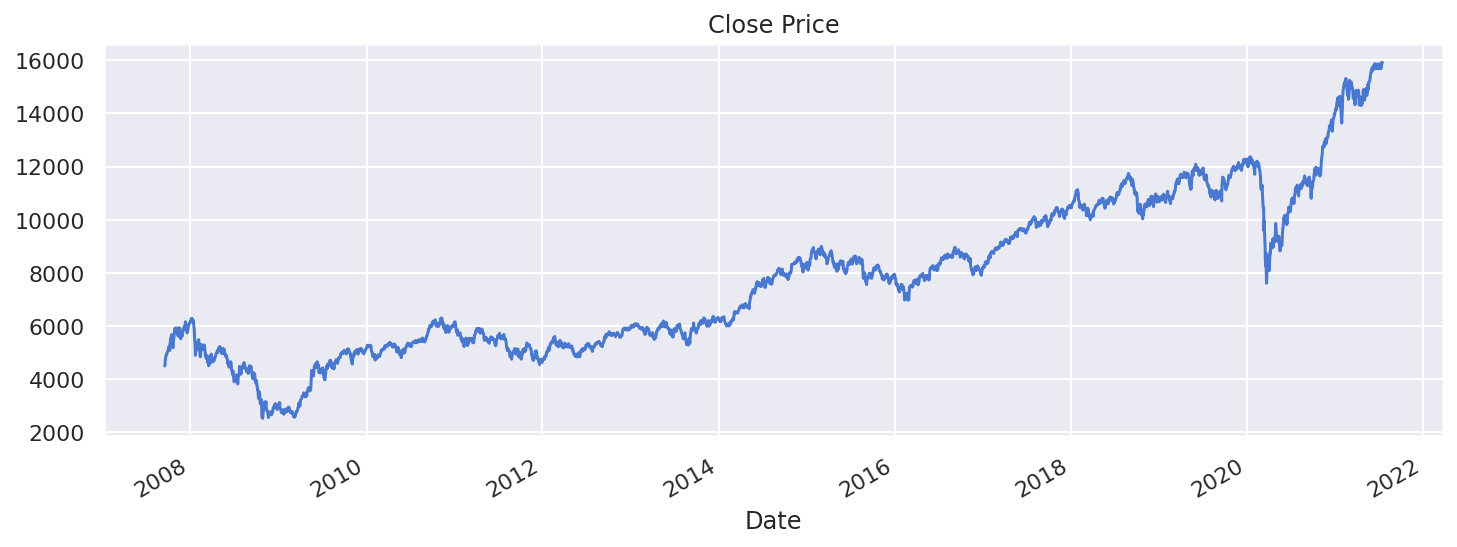

In [35]:
price_df = sp500_df['Close']
price_df.plot()
plt.title('Close Price')
plt.show()

As expected, we can see the bursting of the dot-com bubble between 2000-2004, as well as the 2008 financial crisis.

## Resampling
Since the markets are closed over weekends, let's resample to evenly-spaced daily values and focus on detecting crashes after 1980:

In [36]:
start_year = '2007'
# use pad to replace missing values by last non-missing value
price_resampled_df = price_df.resample('24H').pad()[start_year:]

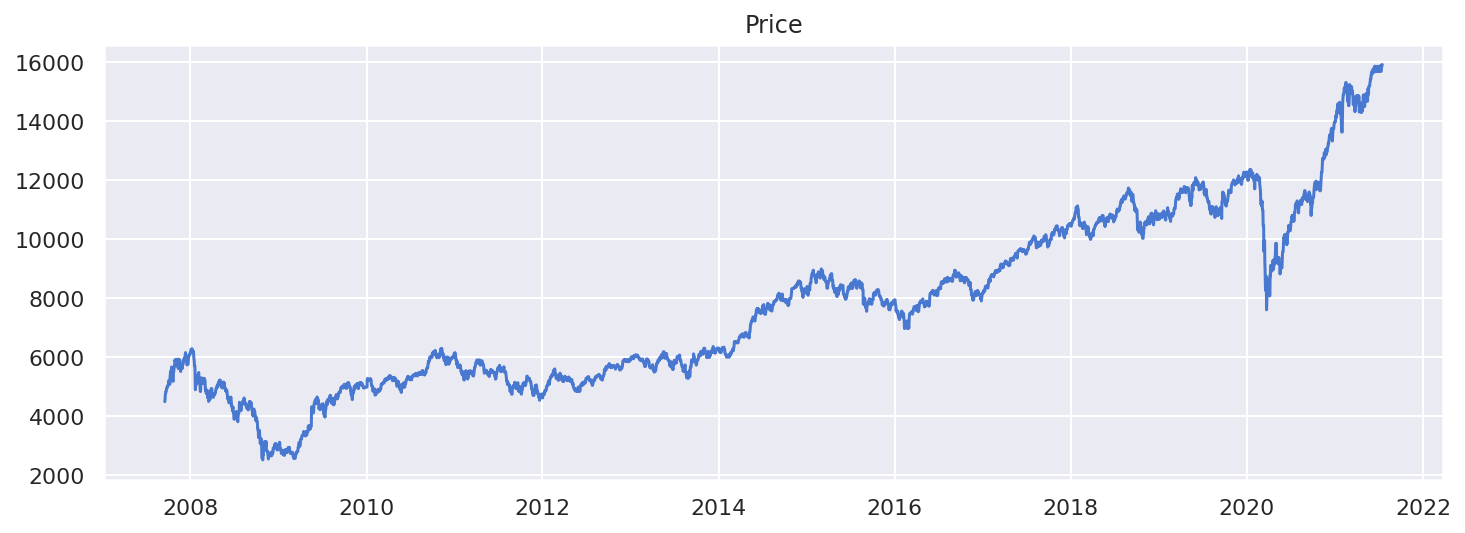

In [37]:
plt.plot(price_resampled_df)
plt.title('Price')
plt.show()

## Time series as point clouds -- Takens' embedding

Discrete time series – that is, time series indexed by a sequence of times $t_0, t_1, \ldots$ – are typically visualised as scatter plots in two dimensions. Points in the plot have times $t_i$ as their horizontal co-ordinates, and the corresponding values $y(t_i)$ of the variable of interest, $y$, as their vertical co-ordinates.

This representation makes the **_local_** behaviour of the time series easy to track by scanning the plot from left to right. But it is often ineffective at conveying important effects which may be occurring over larger time scales.

One well-known set of techniques for capturing **_periodic_** behaviour comes from Fourier analysis. For instance, the [discrete Fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_Transform) of a temporal window over the time series gives information on whether the signal in that window arises as the sum of a few simple periodic signals.

Here we want to present a different way of encoding a time-evolving process. It is based on the idea that some key properties of the dynamics (including, but more general than, periodicity or quasi-periodicity as seen by Fourier analysis) can be unveiled very effectively in higher dimensions. We will be able to represent a univariate time series (or a single temporal window over that time series) as a **_point cloud_**, i.e. a set of vectors in a Euclidean space of arbitrary dimension.

The procedure works as follows: we pick two integers $d$ and $\tau$. For each time $t_i \in (t_0, t_1, \ldots )$, we collect the values of the variable $y$ at $d$ distinct times, evenly spaced by $\tau$ and starting at $t_i$, and present them as a vector with $d$ entries, namely $Y_{t_i} = (y_{t_i}, y_{t_i + \tau}, \ldots , y_{t_i + (d-1)\tau})$. The result is a set of vectors in $d$-dimensional space! $\tau$ is called the **_time delay_** parameter, and $d$ the **_embedding dimension_**.

This **_time-delay embedding_** technique is also called **_Takens' embedding_** after Floris Takens, who demonstrated its significance with a celebrated [theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem) in the context of *nonlinear* dynamical systems.

The **_outer window_** allows us to apply Takens embedding locally on a certain interval rather than over the whole time series. The result of this procedure is therefore a time series of point clouds with possibly interesting topologies.

In [38]:
embedding_dimension = 3
embedding_time_delay = 2

Next we need to initialise the embedder to represent the price time series as a time series of point clouds:

In [39]:
embedder = ts.SingleTakensEmbedding(
    parameters_type="fixed",
    dimension=embedding_dimension,
    time_delay=embedding_time_delay,
    n_jobs=-1,
)

Now that our embedder is initialised, it is a simple matter to obtain an array of embeddings, where each element is a 3-dimensional vector:

In [40]:
price_values = price_resampled_df.values
price_embedded = embedder.fit_transform(price_values)

embedder_time_delay = embedder.time_delay_
embedder_dimension = embedder.dimension_

Next we apply a sliding window to obtain the point clouds per window. We choose the window size such that each interval will span a period of 36 days:

In [41]:
window_size = 31
window_stride = 4

In [42]:
sliding_window = ts.SlidingWindow(size=window_size, stride=window_stride)
price_embedded_windows = sliding_window.fit_transform(price_embedded)

Now that we have our point clouds, let's visualise one of them:

In [43]:
window_num = 42
point_cloud = price_embedded_windows[window_num][:, :3]
plot_point_cloud(point_cloud)

## A simple baseline
Here we create a simple baseline that tracks the first derivative of our time series over a sliding window. By using the `SlidingWindow` class from `giotto-learn` we can quickly obtain arrays that are amenable for the `scikit-learn` APIs:

In [44]:
window_size_price = window_size + embedder_dimension * embedder_time_delay - 2
sliding_window_price = ts.SlidingWindow(size=window_size_price, stride=window_stride)
window_indices = sliding_window_price.slice_windows(price_values)
price_windows = sliding_window_price.fit_transform(price_values)

In [45]:
abs_derivative_of_means = np.abs(np.mean(np.diff(price_windows, axis=0), axis=1))

In [46]:
# define time index to combine with numpy arrays
indices = [win[1] - 1 for win in window_indices[1:]]
time_index_derivs = price_resampled_df.iloc[indices].index

In [47]:
resampled_close_price_derivs = price_resampled_df.loc[time_index_derivs]

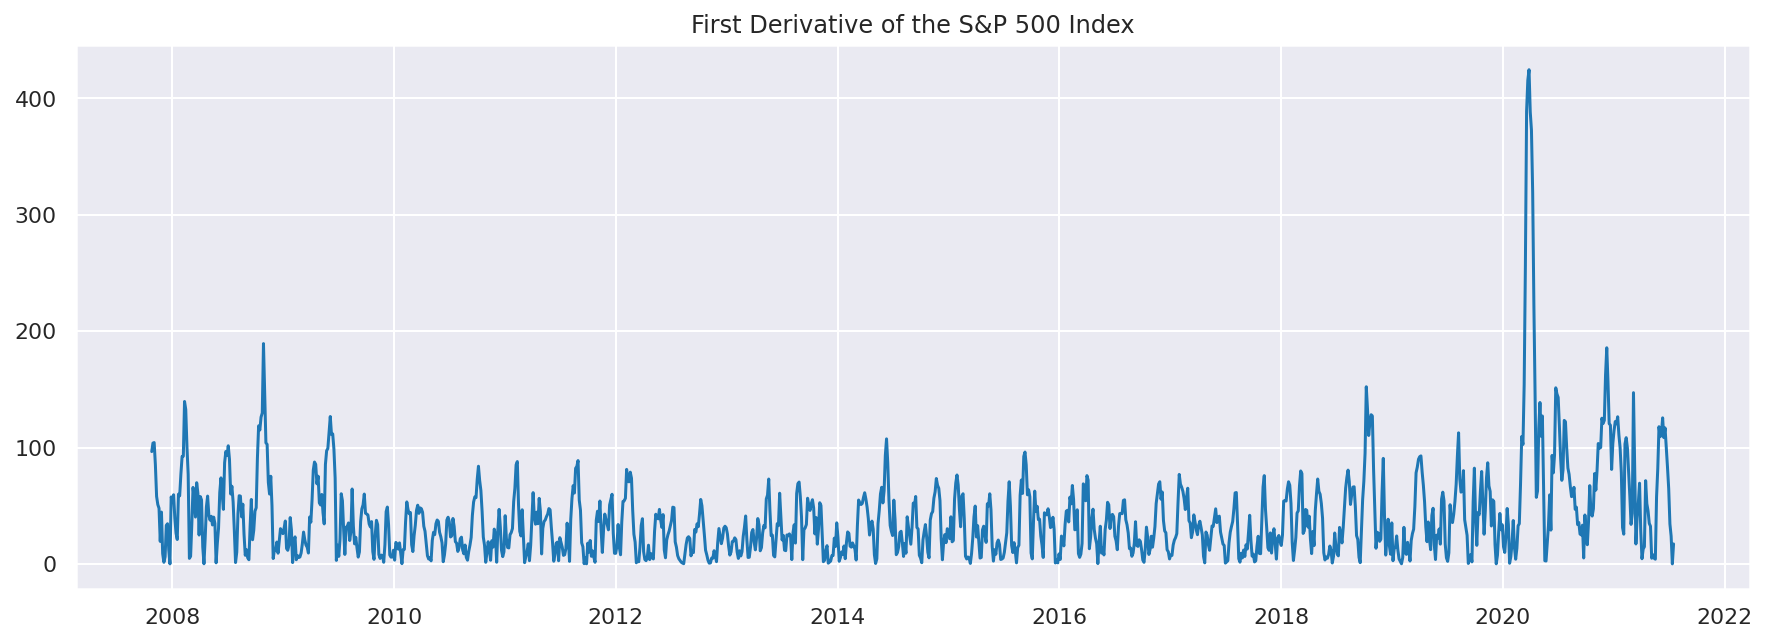

In [48]:
plt.figure(figsize=(15,5))
plt.plot(time_index_derivs, abs_derivative_of_means, color='#1f77b4')
plt.title('First Derivative of the S&P 500 Index')
plt.savefig('metric_first_derivative.png')
plt.show()

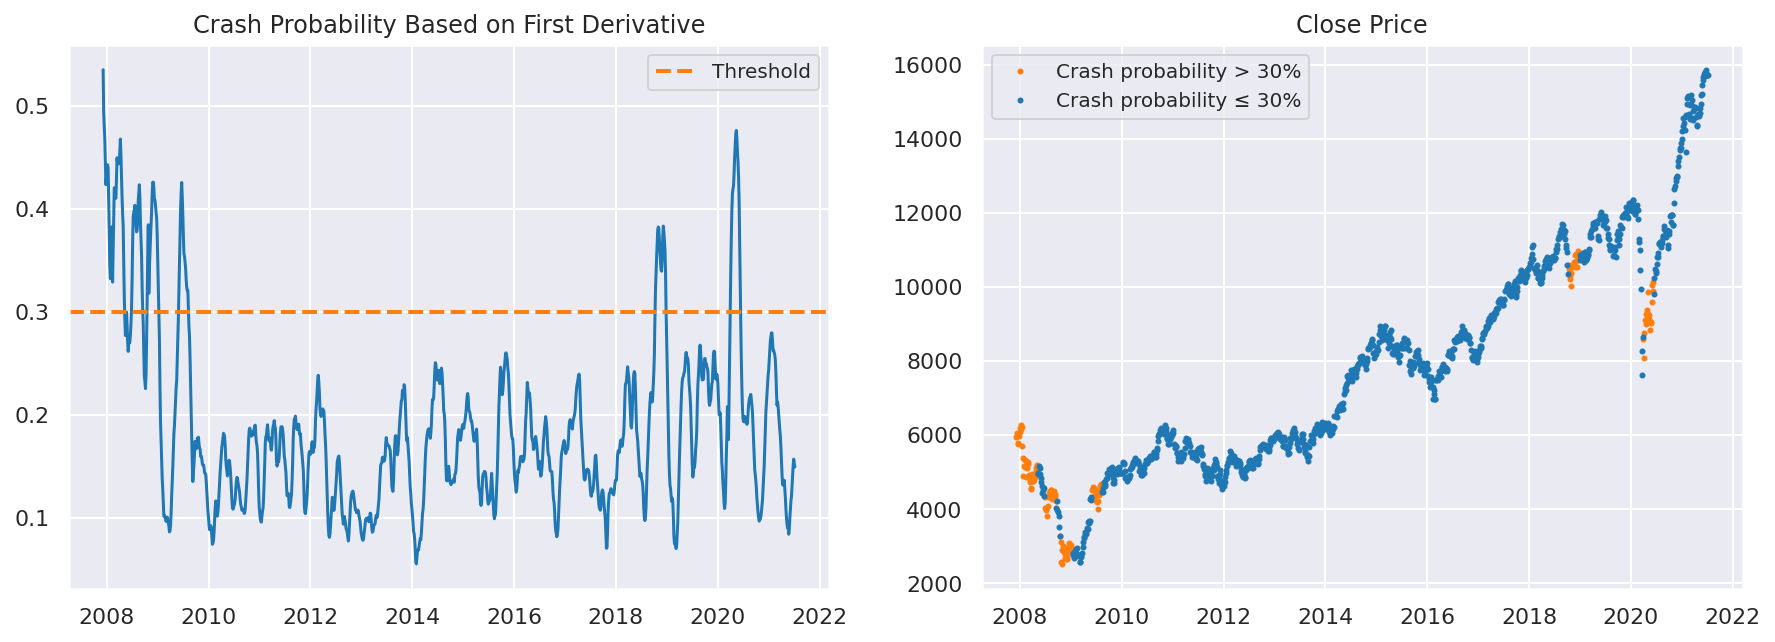

In [53]:
plot_crash_detections(
    start_date="2007-12-01",
    end_date="2021-07-10",
    threshold=0.3,
    distances=abs_derivative_of_means,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='First Derivative'
)

From the plot we see that the first derivative appears to give an indication of where crashes have happened in the past, albeit with quite some noise around each event. Let's see if we can do better with TDA!

## Persistence diagrams

The first step in a TDA pipeline typically involves calculating persistence diagrams, which encode topological information on the dynamics in the embedding space. The horizontal axis corresponds to the moment in which a homological generator is born, while the vertical axis corresponds to the moments in which an homological generator dies.

In [54]:
# define the number of homology dimensions to track
homology_dimensions = (0, 1)
VR = hl.VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=-1)
diagrams = VR.fit_transform(price_embedded_windows)

In the plot below for a single window, the generators of each homology dimension $H_0$ and $H_1$ are coloured differently:

In [55]:
VR.plot(diagrams, sample=window_num)

## Homological derivatives

Given a persistence diagram, there are a number of possible features that can derived from it. For our application, we are interested in calculating the distance between diagrams obtained from two successive windows. Although one can calculate this directly from the `PairwiseDistance` class, we show below how one can make use of `giotto-learn`'s API to create a custom transformer:

In [56]:
from joblib import Parallel, delayed, effective_n_jobs

from sklearn.utils import gen_even_slices
from sklearn.utils.validation import check_is_fitted

from gtda.diagrams import PairwiseDistance
from gtda.diagrams._metrics import _parallel_pairwise, landscapes, betti_curves
from gtda.diagrams._utils import _subdiagrams
from gtda.utils.validation import check_diagrams


class HomologicalDerivative(PairwiseDistance):
    def __init__(self, **kw_args):
        super().__init__(**kw_args)

    def _derivatives_generic(self, X, s):

        return np.array(
            [
                _parallel_pairwise(
                    np.expand_dims(X[t + 1], axis=0),
                    np.expand_dims(X[t], axis=0),
                    self.metric,
                    self.effective_metric_params_,
                    self.homology_dimensions_,
                    self.n_jobs,
                )[0, 0]
                for t in range(s.start, s.stop, 1)
            ]
        )

    def _derivatives(self, subdiagrams, kind, dim, params):
        n_samples, n_points = subdiagrams.shape[:2]
        if kind == "landscape":
            n_layers = min(params["n_layers"], n_points)
            features = landscapes(subdiagrams, params["samplings"][dim], n_layers)
        elif kind == "betti":
            features = betti_curves(subdiagrams, params["samplings"][dim])
        features = (features[1:] - features[:-1]).reshape(n_samples - 1, -1)
        features = np.linalg.norm(features, axis=1, ord=params["p"])

        return (params["step_sizes"][dim] ** (1 / params["p"])) * features

    def fit(self, X, y=None):
        super().fit(X, y)

        return self

    def transform(self, X, y=None):
        check_is_fitted(self, ["effective_metric_params_", "homology_dimensions_"])
        X = check_diagrams(X)

        if self.metric in ["landscape", "betti"]:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives)(
                    _subdiagrams(X[s.start : s.stop + 1], [dim], remove_dim=True),
                    self.metric,
                    dim,
                    self.effective_metric_params_,
                )
                for dim in self.homology_dimensions_
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)
            Xt = Xt.reshape(len(self.homology_dimensions_), len(X) - 1).T
        else:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives_generic)(X, s)
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)

        if self.order is not None:
            Xt = np.linalg.norm(Xt, axis=1, ord=self.order)

        return Xt

### Landscape distances

With our transformer defined, let's use it to calculate the successive distance between diagrams using the landscape distance:

In [57]:
metric_params = {"p": 2, "n_layers": 10, "n_bins": 1000}

landscape_hom_der = HomologicalDerivative(
    metric="landscape", metric_params=metric_params, order=2, n_jobs=-1
)
landscape_succ_dists = landscape_hom_der.fit_transform(diagrams)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



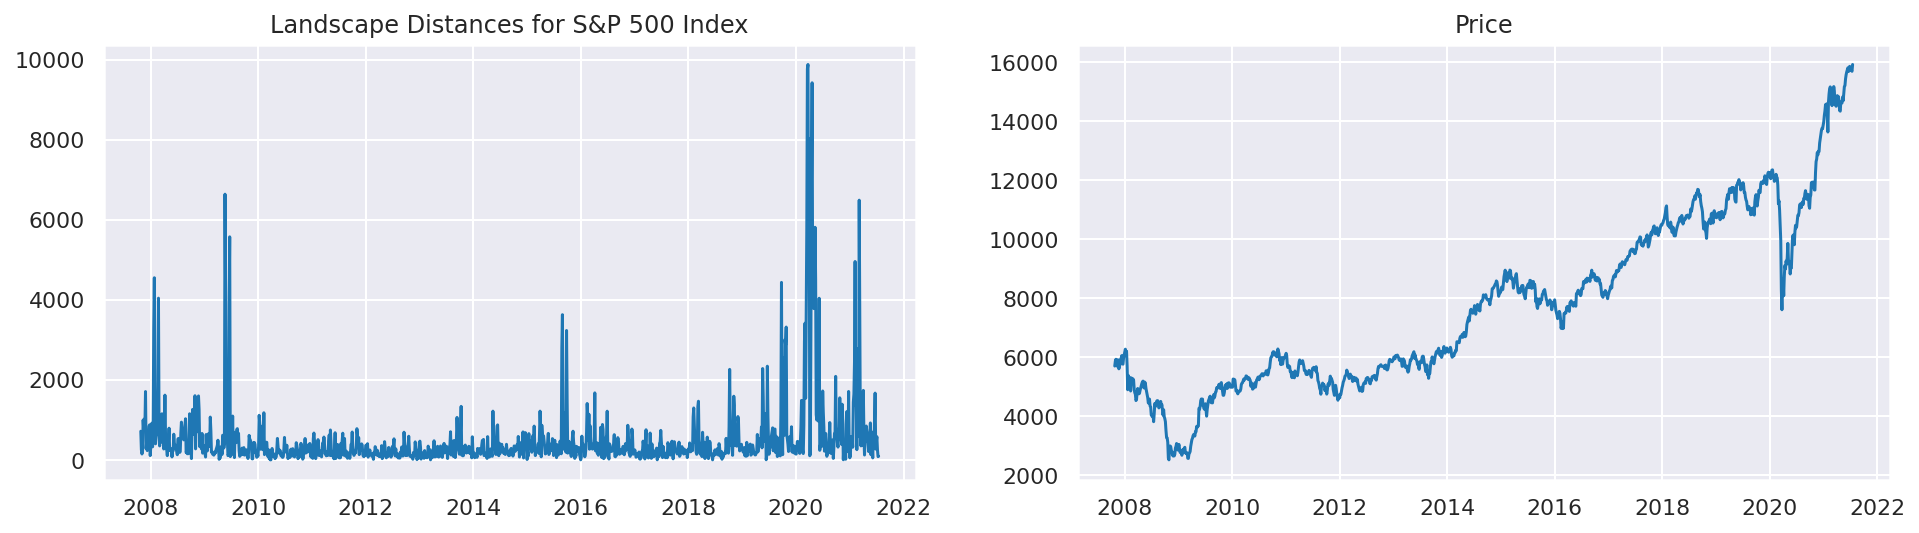

In [58]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, color="#1f77b4")
plt.title("Landscape Distances for S&P 500 Index")

plt.subplot(1, 2, 2)
plt.plot(resampled_close_price_derivs, "#1f77b4")
plt.title("Price")
plt.show()

## Distances among diagrams using Betti curves

In this section we show how to compute distances among persistece diagrams. There are many notions of distances: here we use the $l^p$ *norm of the Betti curves*.

In [59]:
metric_params = {"p": 2, "n_bins": 1000}


bettiHomDer = HomologicalDerivative(
    metric='betti', metric_params=metric_params, order=2, n_jobs=-1
)
betti_succ_dists = bettiHomDer.fit_transform(diagrams)

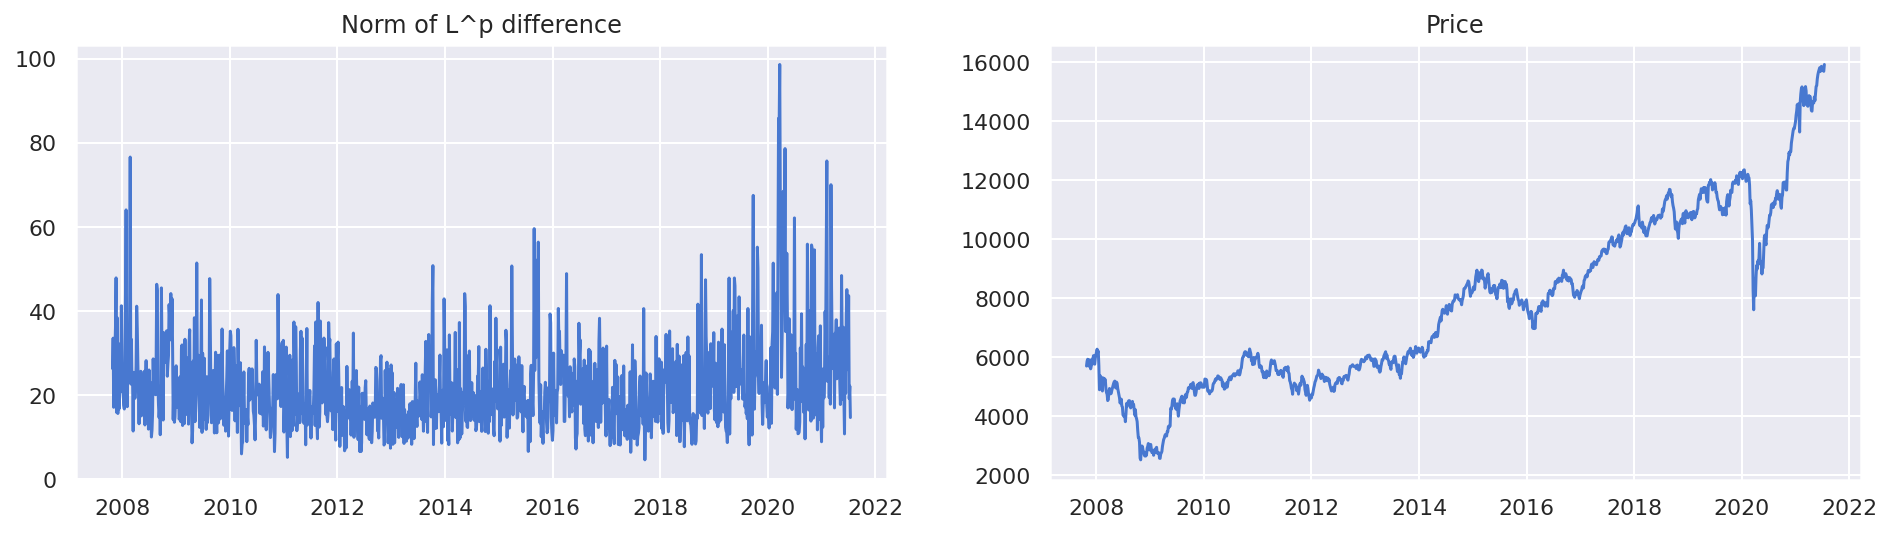

In [60]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, betti_succ_dists)
plt.title('Norm of L^p difference')

plt.subplot(1, 2, 2)
plt.plot(resampled_close_price_derivs)
plt.title('Price')
plt.show()

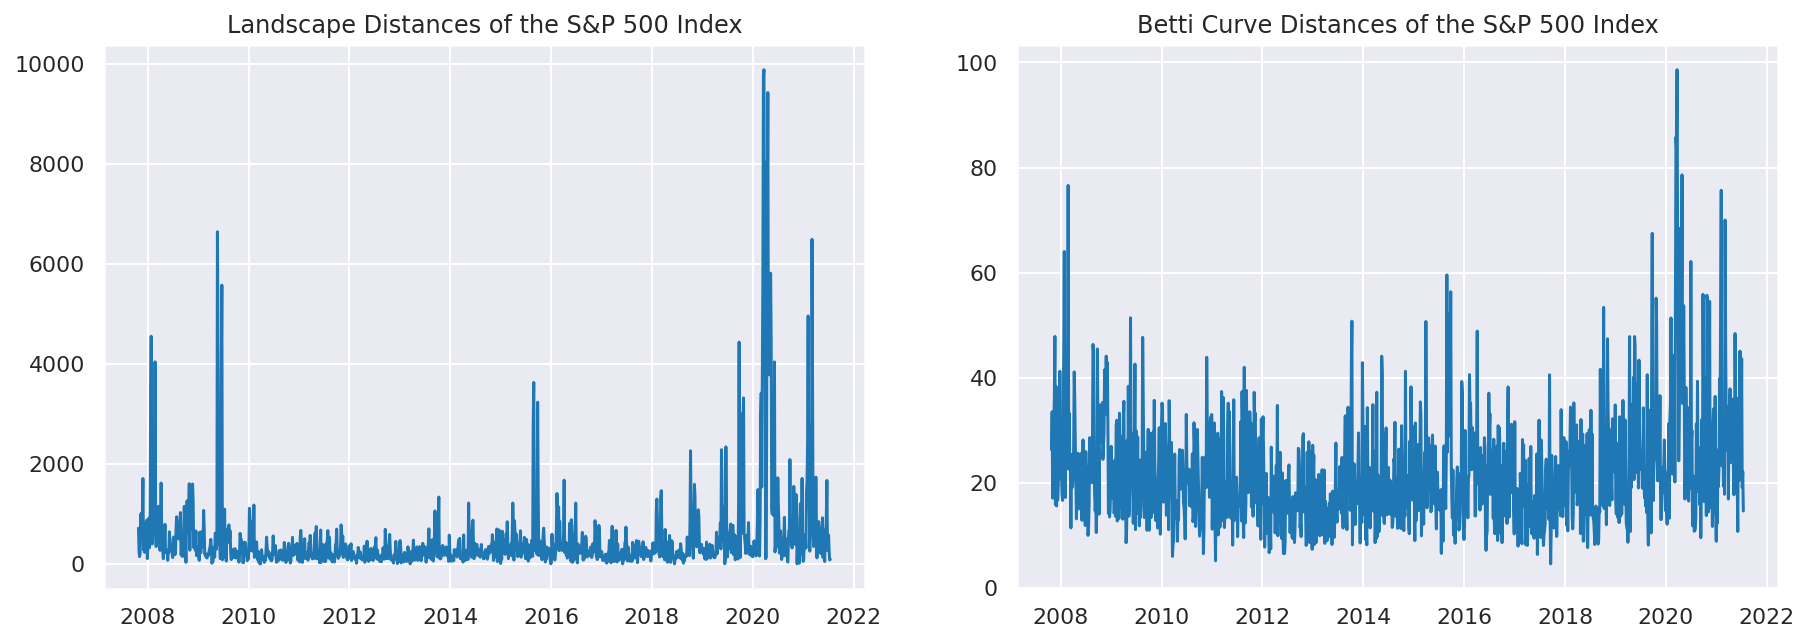

In [62]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(time_index_derivs, landscape_succ_dists, "#1f77b4")
plt.title("Landscape Distances of the S&P 500 Index")

plt.subplot(1, 2, 2)
plt.plot(time_index_derivs, betti_succ_dists, "#1f77b4")
plt.title('Betti Curve Distances of the S&P 500 Index')
#plt.savefig('./images/metric_landscape_betti.png')
plt.show()

## Topological indicators for crashes
By comparing the different ways to measure change of topological signature, it seems that the landscape approach carries more information and is more robust to noise, let's investigate a bit more what is happening around selected market crashes using the landscape distance.

Let's investigate the last two major market crashes.

* **dot-com crash:** from March 11, 2000, to October 9, 2004

* **Subprime mortgage crisis:**  from  December 2007 – June 2009


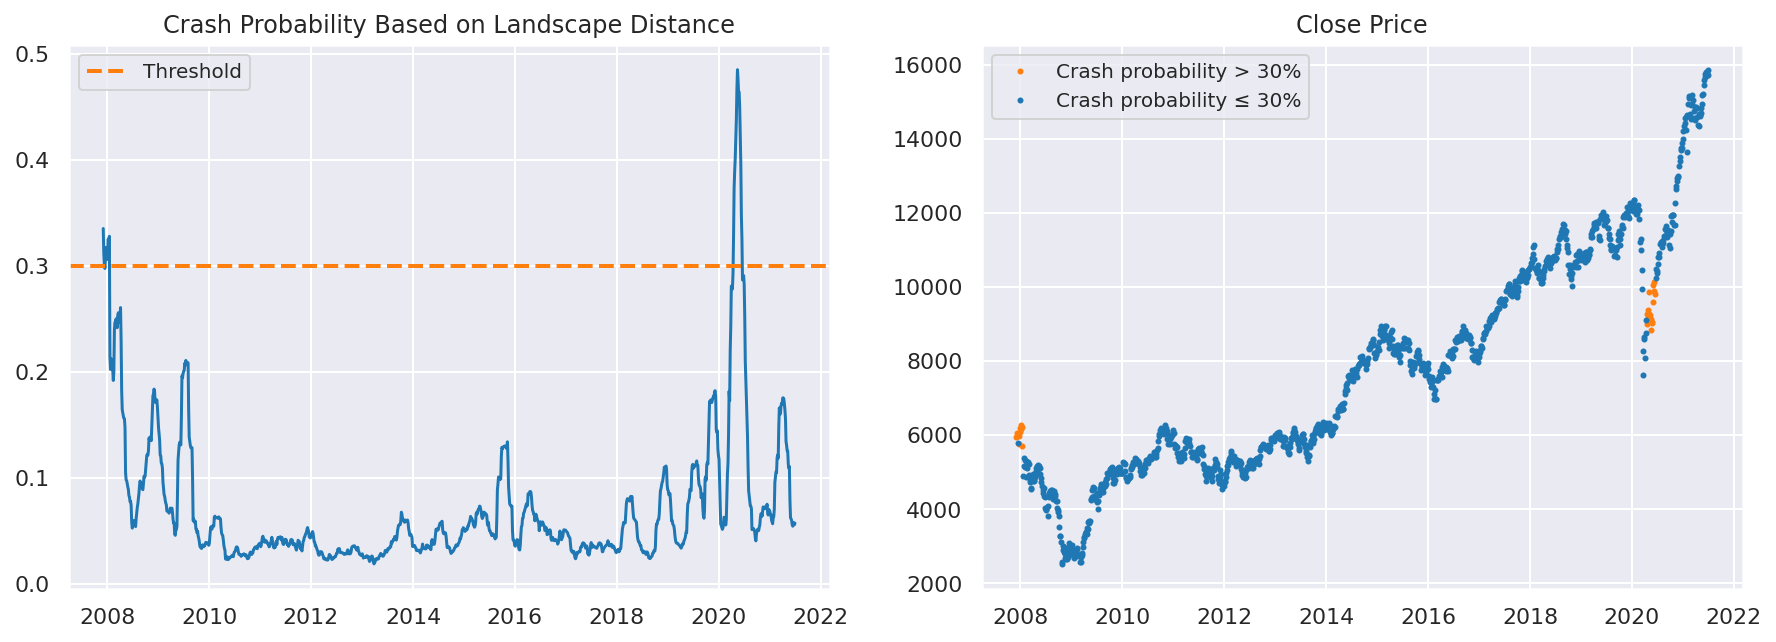

In [64]:
plot_crash_detections(
    start_date="2007-12-01",
    end_date="2021-07-01",
    threshold=0.3,
    distances=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Landscape Distance'
)

From the plot on the right-hand side we see that our simple metric has been able to correctly identify the region in time when the dot-com bubble began to burst! Let's now examine the financial crisis from 2008:

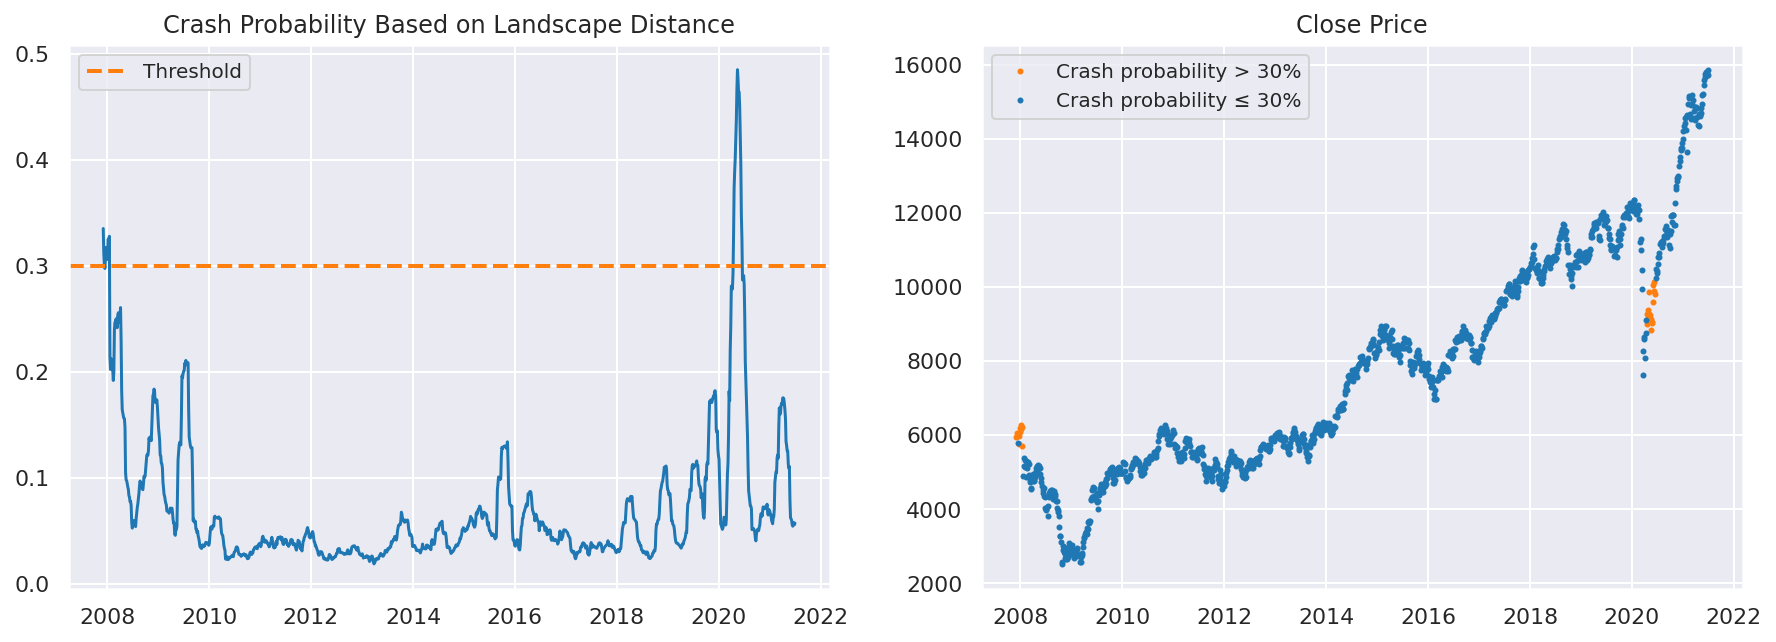

In [65]:
plot_crash_detections(
    start_date="2007-12-01",
    end_date="2021-07-01",
    threshold=0.3,
    distances=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
    metric_name='Landscape Distance'
)

Again we see that the homological derivative has captured part of the region where the market was crashing. As a final comparison, let us compare the baseline model against our topological features:

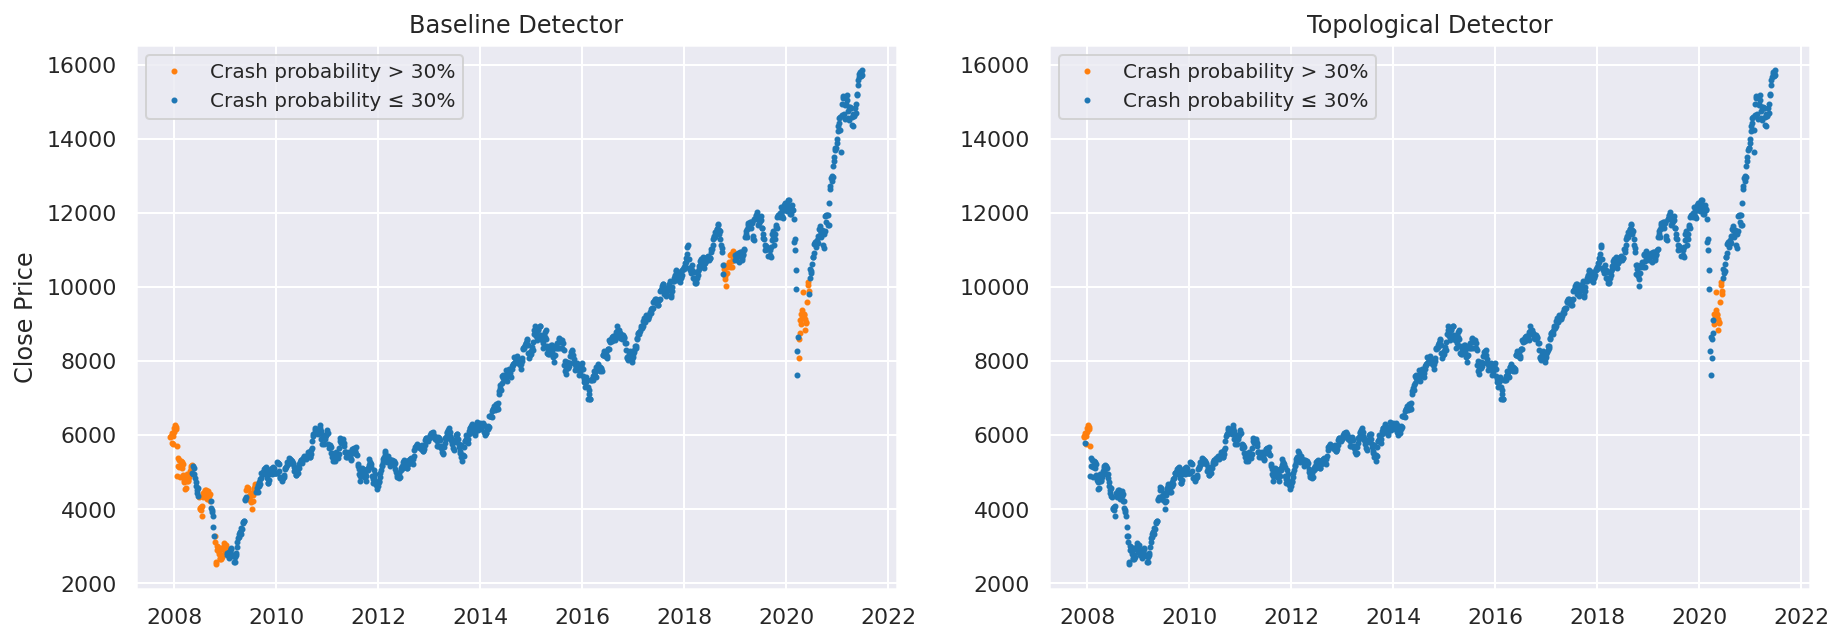

In [66]:
plot_crash_comparisons(
    start_date="2007-12-01",
    end_date="2021-07-01",
    threshold=0.3,
    distances_1=abs_derivative_of_means,
    distances_2=landscape_succ_dists,
    time_index_derivs=time_index_derivs,
    price_resampled_derivs=resampled_close_price_derivs,
)